# Synthetic Discussions analysis

## Preprocessing

In [1]:
%cd ..

/home/dimits/Documents/research/llm_moderation/experiments


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tasks import preprocessing


CONVERSATION_DIR = "data/generated_discussions_output"
ANNOTATION_DIR = "data/annotations_output" 

In [3]:
import re


def extract_sdb_attributes(prompt: str):
    # generated by ChatGPT
    attributes = {}

    # Extracting age based on the pattern "NN years old"
    age_match = re.search(r'(\d{2})\s+years\s+old', prompt, re.IGNORECASE)
    attributes['age'] = int(age_match.group(1)) if age_match else None

    # Extracting potential gender by searching for words like "man", "woman"
    gender_match = re.search(r'\b(man|woman|non-binary)\b', prompt, re.IGNORECASE)
    attributes['gender'] = gender_match.group(1).capitalize() if gender_match else None

    # Extracting profession based on the assumption it appears after an age or gender mention
    profession_match = re.search(r'\b(?:[A-Z][a-z]+(?:\s[A-Z][a-z]+)*)\b', prompt)
    if profession_match:
        attributes['profession'] = profession_match.group(0)

    # Extracting education level based on patterns like "with [education] education"
    education_match = re.search(r'\bwith\s+([A-Z][a-z]+(?:\s[A-Z][a-z]+)?)\s+education\b', prompt)
    attributes['education'] = education_match.group(1) if education_match else None
    
    # Identifying if a non-heterosexual orientation exists
    non_hetero_match = re.search(r'\b(?!Heterosexual\b)[A-Z][a-z]*sexual\b', prompt)
    attributes['is_heterosexual'] = not bool(non_hetero_match)
    
    # Extracting intent if it follows "and" and ends the sentence
    intent_match = re.search(r'\band\s+([A-Z][a-z]+)\s+intent\b', prompt)
    attributes['intent'] = intent_match.group(1).capitalize() if intent_match else None

    # Extracting traits as any lowercase words that aren't matched by the above patterns
    # This assumes traits are adjectives or descriptive words/phrases
    matched_text = set(match.group() for match in re.finditer(r'\b[a-z]+\b', prompt))
    extracted_values = {str(value).lower() for key, value in attributes.items() if value}
    unmatched_traits = matched_text - extracted_values
    attributes['traits'] = list(unmatched_traits)
    
    return attributes

### Importing the synthetic conversations

In [4]:
conv_df = preprocessing.import_conversations(CONVERSATION_DIR)
conv_df = conv_df.loc[:,["id", "user_prompts", "user", "message", "moderator_prompt"]]
conv_df

,id,user_prompts,user,message,moderator_prompt
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,"[You are WiseOwl71 71 years old, Heterosexual,...",DarkShadow333,I'm so sick of people making excuses for terro...,You are moderator . Context: You are a human p...
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,"[You are WiseOwl71 71 years old, Heterosexual,...",moderator,"@DarkShadow333, I understand your frustration,...",You are moderator . Context: You are a human p...
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,"[You are WiseOwl71 71 years old, Heterosexual,...",TechGuru88,I'm not sure what kind of world we're living i...,You are moderator . Context: You are a human p...
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,"[You are WiseOwl71 71 years old, Heterosexual,...",moderator,,You are moderator . Context: You are a human p...
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,"[You are WiseOwl71 71 years old, Heterosexual,...",WiseOwl71,I couldn't agree more with @TechGuru88. It's a...,You are moderator . Context: You are a human p...
...,...,...,...,...,...
0,71323709-ef1f-46d1-845e-425f38d44a7c,"[You are QueenOfChaos 32 years old, Heterosexu...",moderator,"@TechGuru88, I understand your frustration and...","You are moderator just, strict, understanding...."
0,71323709-ef1f-46d1-845e-425f38d44a7c,"[You are QueenOfChaos 32 years old, Heterosexu...",WiseOwl71,I'm glad someone finally spoke up against this...,"You are moderator just, strict, understanding...."
0,71323709-ef1f-46d1-845e-425f38d44a7c,"[You are QueenOfChaos 32 years old, Heterosexu...",moderator,,"You are moderator just, strict, understanding...."
0,71323709-ef1f-46d1-845e-425f38d44a7c,"[You are QueenOfChaos 32 years old, Heterosexu...",doing_my_best24,"I understand your frustration @WiseOwl71, but ...","You are moderator just, strict, understanding...."


In [5]:
# separate the prompt of the user who is speaking
def extract_user_prompt(prompts, user):
    for prompt in prompts:
        if f"You are {user}" in prompt:
            return prompt
    return None  # If no prompt matches


def sdb_portion(prompt: str) -> str:
    return prompt.split("Context:")[0]


conv_df["user_prompt"] = conv_df.apply(
    lambda row: extract_user_prompt(row["user_prompts"], row["user"]),
    axis=1,
)
conv_df["user_prompt"] = conv_df.apply(
    lambda row: (
        row["moderator_prompt"] if row["user"] == "moderator" else row["user_prompt"]
    ),
    axis=1,
)
conv_df["user_prompt"] = conv_df["user_prompt"].apply(sdb_portion)
conv_df = conv_df.loc[:, ["id", "user_prompt", "user", "message"]]
conv_df

,id,user_prompt,user,message
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,"You are DarkShadow333 29 years old, Homosexual...",DarkShadow333,I'm so sick of people making excuses for terro...
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,You are moderator .,moderator,"@DarkShadow333, I understand your frustration,..."
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,"You are TechGuru88 35 years old, Heterosexual,...",TechGuru88,I'm not sure what kind of world we're living i...
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,You are moderator .,moderator,
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,"You are WiseOwl71 71 years old, Heterosexual, ...",WiseOwl71,I couldn't agree more with @TechGuru88. It's a...
...,...,...,...,...
0,71323709-ef1f-46d1-845e-425f38d44a7c,"You are moderator just, strict, understanding.",moderator,"@TechGuru88, I understand your frustration and..."
0,71323709-ef1f-46d1-845e-425f38d44a7c,"You are WiseOwl71 71 years old, Heterosexual, ...",WiseOwl71,I'm glad someone finally spoke up against this...
0,71323709-ef1f-46d1-845e-425f38d44a7c,"You are moderator just, strict, understanding.",moderator,
0,71323709-ef1f-46d1-845e-425f38d44a7c,"You are doing_my_best24 24 years old, Bisexual...",doing_my_best24,"I understand your frustration @WiseOwl71, but ..."


In [6]:
demographics_df = (
    conv_df["user_prompt"].apply(extract_sdb_attributes).apply(pd.Series)
)
demographics_df = demographics_df.rename(
    {
        "age": "user_age",
        "ethnicity": "user_ethnicity",
        "is_heterosexual": "user_is_heterosexual",
        "profession": "user_profession",
        "gender": "user_gender",
        "education": "user_education",
        "intent": "user_intent"
    },
    axis=1,
)
demographics_df

,user_age,user_gender,user_profession,user_education,user_is_heterosexual,user_intent,traits
0,29.0,Man,You,High School,False,Troll,"[provocative, rebellious, with, years, and, in..."
0,NaN,None,You,None,True,None,"[moderator, are]"
0,35.0,Man,You,Masters,True,Helpful,"[with, years, and, methodical, intent, old, hu..."
0,NaN,None,You,None,True,None,"[moderator, are]"
0,71.0,Woman,You,None,True,Helpful,"[calm, with, years, patient, and, analytical, ..."
...,...,...,...,...,...,...,...
0,NaN,None,You,None,True,None,"[strict, just, understanding, moderator, are]"
0,71.0,Woman,You,None,True,Helpful,"[calm, with, years, patient, and, analytical, ..."
0,NaN,None,You,None,True,None,"[strict, just, understanding, moderator, are]"
0,24.0,Woman,You,College,False,Neutral,"[calm, artistic, with, agreeable, years, and, ..."


In [7]:
conv_df = pd.concat(
    [conv_df, demographics_df], axis=1
)
conv_df = conv_df[
    [
        "id",
        "user",
        "message",
        "user_age",
        "user_is_heterosexual",
        "user_profession",
        "user_gender",
        "user_intent"
    ]
]
conv_df

,id,user,message,user_age,user_is_heterosexual,user_profession,user_gender,user_intent
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,DarkShadow333,I'm so sick of people making excuses for terro...,29.0,False,You,Man,Troll
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,moderator,"@DarkShadow333, I understand your frustration,...",NaN,True,You,None,None
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,TechGuru88,I'm not sure what kind of world we're living i...,35.0,True,You,Man,Helpful
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,moderator,,NaN,True,You,None,None
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,WiseOwl71,I couldn't agree more with @TechGuru88. It's a...,71.0,True,You,Woman,Helpful
...,...,...,...,...,...,...,...,...
0,71323709-ef1f-46d1-845e-425f38d44a7c,moderator,"@TechGuru88, I understand your frustration and...",NaN,True,You,None,None
0,71323709-ef1f-46d1-845e-425f38d44a7c,WiseOwl71,I'm glad someone finally spoke up against this...,71.0,True,You,Woman,Helpful
0,71323709-ef1f-46d1-845e-425f38d44a7c,moderator,,NaN,True,You,None,None
0,71323709-ef1f-46d1-845e-425f38d44a7c,doing_my_best24,"I understand your frustration @WiseOwl71, but ...",24.0,False,You,Woman,Neutral


### Importing the synthetic annotations

In [8]:
annot_df = preprocessing.import_annotations(ANNOTATION_DIR, round=True, sentinel_value=-1)
annot_df = annot_df[annot_df.toxicity != -1]
annot_df = annot_df[["conv_id", "annotator_prompt", "message", "toxicity"]]
annot_df

,conv_id,annotator_prompt,message,toxicity
0,e1a8533f-690b-4b4f-a8bc-78ad287f8129,"You are 30 years old, Bisexual, African Ameri...","**Comment:** @QueenOfChaos, you're absolutely...",4
0,e1a8533f-690b-4b4f-a8bc-78ad287f8129,"You are 30 years old, Bisexual, African Ameri...","**Comment:** @GoldenYears66, you're absolutel...",4
0,e1a8533f-690b-4b4f-a8bc-78ad287f8129,"You are 30 years old, Bisexual, African Ameri...","**Comment:** @GoldenYears66, I think your arg...",4
0,e1a8533f-690b-4b4f-a8bc-78ad287f8129,"You are 30 years old, Bisexual, African Ameri...","**Comment:** @TechGuru88, I understand your p...",1
0,e1a8533f-690b-4b4f-a8bc-78ad287f8129,"You are 30 years old, Bisexual, African Ameri...",**Comment:** I'm not sure what's more disturb...,4
...,...,...,...,...
0,55a46846-74f8-463a-9dff-f116bb9daa8c,"You are 30 years old, Bisexual, African Ameri...",@DarkShadow333 I couldn't agree more with your...,1
0,55a46846-74f8-463a-9dff-f116bb9daa8c,"You are 30 years old, Bisexual, African Ameri...",@GoldenYears66 I couldn't agree more with your...,1
0,55a46846-74f8-463a-9dff-f116bb9daa8c,"You are 30 years old, Bisexual, African Ameri...",@TechGuru88 You're so naive. You think the wor...,3
0,55a46846-74f8-463a-9dff-f116bb9daa8c,"You are 30 years old, Bisexual, African Ameri...",I'm not sure what kind of world @QueenOfChaos ...,2


In [9]:
demographics_df = (
    annot_df["annotator_prompt"].apply(extract_sdb_attributes).apply(pd.Series)
)
annot_df = pd.concat(
    [annot_df.drop(columns=["annotator_prompt"]), demographics_df], axis=1
)
annot_df = annot_df.rename(
    {
        "age": "annotator_age",
        "ethnicity": "annotator_ethnicity",
        "is_heterosexual": "annotator_is_heterosexual",
        "profession": "annotator_profession",
        "gender": "annotator_gender",
        "education": "annotator_education",
    },
    axis=1,
)
annot_df = annot_df[
    [
        "conv_id",
        "message",
        "toxicity",
        "annotator_age",
        "annotator_is_heterosexual",
        "annotator_profession",
        "annotator_gender",
    ]
]
annot_df

,conv_id,message,toxicity,annotator_age,annotator_is_heterosexual,annotator_profession,annotator_gender
0,e1a8533f-690b-4b4f-a8bc-78ad287f8129,"**Comment:** @QueenOfChaos, you're absolutely...",4,30,False,You,Woman
0,e1a8533f-690b-4b4f-a8bc-78ad287f8129,"**Comment:** @GoldenYears66, you're absolutel...",4,30,False,You,Woman
0,e1a8533f-690b-4b4f-a8bc-78ad287f8129,"**Comment:** @GoldenYears66, I think your arg...",4,30,False,You,Woman
0,e1a8533f-690b-4b4f-a8bc-78ad287f8129,"**Comment:** @TechGuru88, I understand your p...",1,30,False,You,Woman
0,e1a8533f-690b-4b4f-a8bc-78ad287f8129,**Comment:** I'm not sure what's more disturb...,4,30,False,You,Woman
...,...,...,...,...,...,...,...
0,55a46846-74f8-463a-9dff-f116bb9daa8c,@DarkShadow333 I couldn't agree more with your...,1,30,False,You,Woman
0,55a46846-74f8-463a-9dff-f116bb9daa8c,@GoldenYears66 I couldn't agree more with your...,1,30,False,You,Woman
0,55a46846-74f8-463a-9dff-f116bb9daa8c,@TechGuru88 You're so naive. You think the wor...,3,30,False,You,Woman
0,55a46846-74f8-463a-9dff-f116bb9daa8c,I'm not sure what kind of world @QueenOfChaos ...,2,30,False,You,Woman


### Creating a unified dataset

In [10]:
combined_df = conv_df.merge(annot_df, left_on=["id", "message"], right_on=["conv_id", "message"])
combined_df.user_age = combined_df.user_age.astype("Int64")
combined_df = combined_df.drop("conv_id", axis=1)
combined_df.head()

,id,user,message,user_age,user_is_heterosexual,user_profession,user_gender,user_intent,toxicity,annotator_age,annotator_is_heterosexual,annotator_profession,annotator_gender
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,TechGuru88,I'm not sure what kind of world we're living i...,35,True,You,Man,Helpful,4,30,True,You,Woman
1,132b1278-8811-4145-bdfa-bddcc3ef56f9,WiseOwl71,I couldn't agree more with @TechGuru88. It's a...,71,True,You,Woman,Helpful,4,30,False,You,Man
2,132b1278-8811-4145-bdfa-bddcc3ef56f9,WiseOwl71,I couldn't agree more with @TechGuru88. It's a...,71,True,You,Woman,Helpful,4,30,True,You,Man
3,132b1278-8811-4145-bdfa-bddcc3ef56f9,WiseOwl71,I couldn't agree more with @TechGuru88. It's a...,71,True,You,Woman,Helpful,4,70,True,You,Woman
4,132b1278-8811-4145-bdfa-bddcc3ef56f9,GoldenYears66,"@WiseOwl71, I couldn't agree more with your se...",66,True,You,Man,Supportive,4,30,True,You,Woman


## Analysis

In [11]:
sns.set(style="whitegrid")

### User intent impact on toxicity

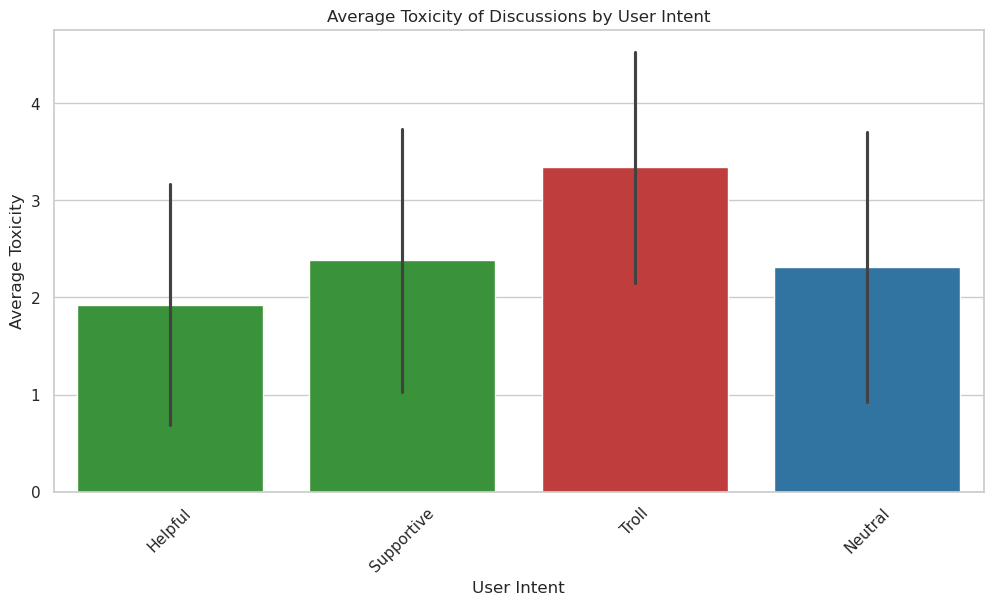

In [12]:
palette = {"Helpful": "tab:green", "Supportive": "tab:green", "Neutral": "tab:blue", "Troll": "tab:red"}
# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=combined_df,
    x="user_intent",
    hue="user_intent",
    y="toxicity",
    errorbar="sd",
    palette=palette,
    legend=False,
)

# Customize the plot
plt.title("Average Toxicity of Discussions by User Intent")
plt.xlabel("User Intent")
plt.ylabel("Average Toxicity")
plt.xticks(rotation=45)
plt.show()

### Progression of toxicity

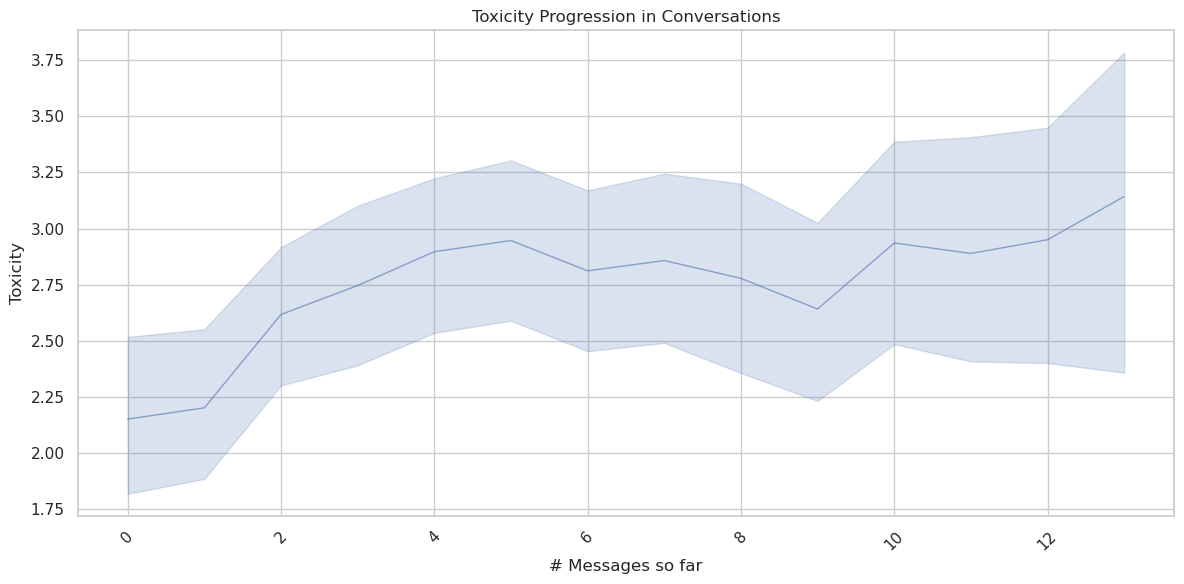

In [13]:
timeseries_df = combined_df.reset_index()
timeseries_df = timeseries_df.drop_duplicates(subset=['id', 'user', 'message'])

# remove moderator 
timeseries_df = timeseries_df[~(timeseries_df.user=="moderator")]

# Filter out conversations with fewer than X comments
conversation_counts = timeseries_df.groupby('id').size()
min_conv_len = 3 
valid_conversations = conversation_counts[conversation_counts >= min_conv_len].index
timeseries_df = timeseries_df[timeseries_df['id'].isin(valid_conversations)]

timeseries_df['message_order'] = timeseries_df.groupby('id').cumcount()

plt.figure(figsize=(12, 6))
sns.lineplot(data=timeseries_df, x='message_order', y='toxicity', legend=None, lw=1, alpha=0.6)
plt.title('Toxicity Progression in Conversations')
plt.xlabel('# Messages so far')
plt.ylabel('Toxicity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

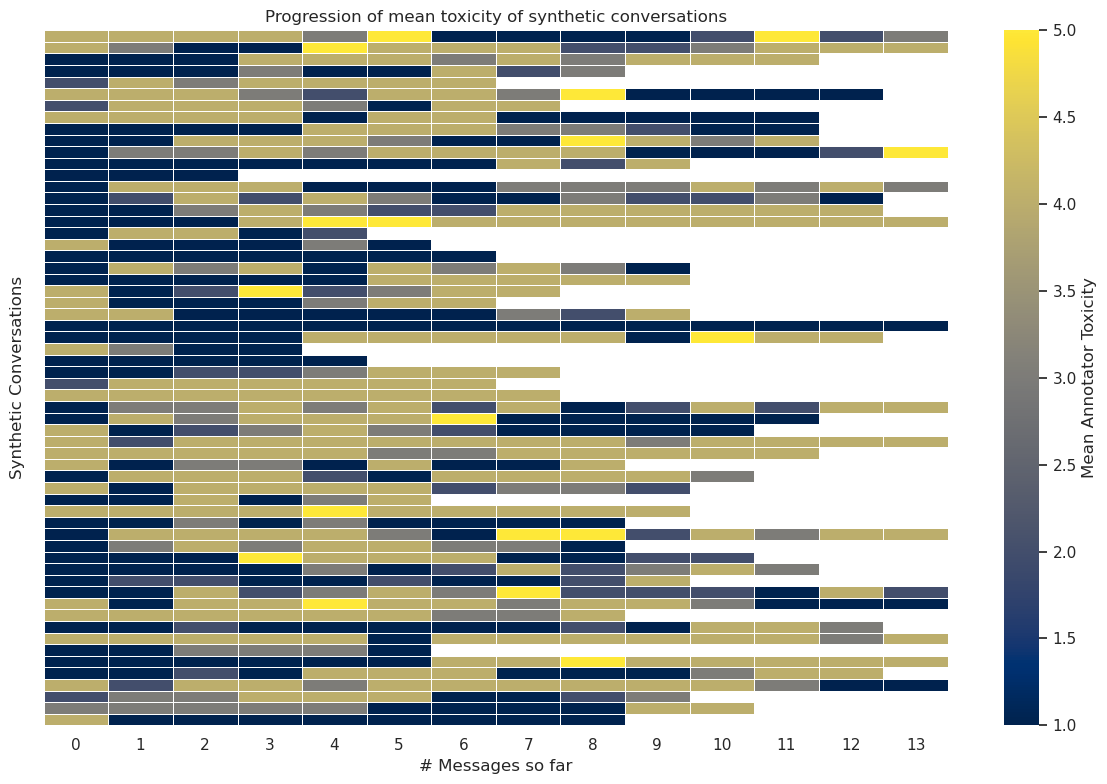

In [14]:
# Calculate the mean toxicity for each message order and conversation
mean_toxicity = timeseries_df.groupby(['id', 'message_order'])['toxicity'].mean().reset_index()

# Pivot the data to create a matrix where rows are conv_id, columns are message_order
heatmap_data = timeseries_df.pivot(index='id', columns='message_order', values='toxicity')

# Create the heatmap plot
plt.figure(figsize=(12, 8))
ax = sns.heatmap(data=heatmap_data, cmap="cividis", cbar_kws={'label': 'Mean Annotator Toxicity'}, linewidths=0.5)
ax.set(yticklabels=[])
ax.grid(False)

plt.title('Progression of mean toxicity of synthetic conversations')
plt.xlabel('# Messages so far')
plt.ylabel('Synthetic Conversations')
plt.tight_layout()
plt.show()